In [1]:
options(warn=-1)
library(h2o)
#If there is a proxy: proxy.old <- Sys.getenv('http_proxy'); Sys.setenv('http_proxy'='');
localH2O =  h2o.init()


----------------------------------------------------------------------

Your next step is to start H2O:
    > h2o.init()

For H2O package documentation, ask for help:
    > ??h2o

After starting H2O, you can use the Web UI at http://localhost:54321
For more information visit https://docs.h2o.ai

----------------------------------------------------------------------


Attaching package: 'h2o'

The following objects are masked from 'package:stats':

    cor, sd, var

The following objects are masked from 'package:base':

    %*%, %in%, &&, ||, apply, as.factor, as.numeric, colnames,
    colnames<-, ifelse, is.character, is.factor, is.numeric, log,
    log10, log1p, log2, round, signif, trunc



 Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         21 hours 2 minutes 
    H2O cluster timezone:       Asia/Shanghai 
    H2O data parsing timezone:  UTC 
    H2O cluster version:        3.36.1.4 
    H2O cluster version age:    8 days  
    H2O cluster name:           H2O_started_from_R_Administrator_snc915 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   4.56 GB 
    H2O cluster total cores:    16 
    H2O cluster allowed cores:  16 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    H2O Internal Security:      FALSE 
    R Version:                  R version 3.6.1 (2019-07-05) 



I. load data

In [24]:
train.file <- 'F:\\assignment1_datasets\\Task2D_labeled.csv'; # use absolute address or relative to the start location of the H2O instance!
train.frame <- h2o.importFile(path = train.file,sep=',') 
train.label <- as.character(as.vector(train.frame[,1]))

untrain.file <- 'F:\\assignment1_datasets\\Task2D_unlabeled.csv'; # use absolute address or relative to the start location of the H2O instance!
untrain.frame <- h2o.importFile(path = untrain.file,sep=',') 
untrain.label <- as.character(as.vector(train.frame[,1]))

test.file <- 'F:\\assignment1_datasets\\Task2D_unlabeled.csv'; # use absolute address or relative to the start location of the H2O instance!
test.frame <- h2o.importFile(path = test.file,sep=',') 
test.label <- as.character(as.vector(test.frame[,1]))

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%


II&III. train auto encoder and analysis

In [4]:
autoencoder_train <-function()
{
    hids = seq(20, 400, 20)
    train_loss = c()
    test_loss = c()
    for(hid in hids)
    {
        NN.model1 = h2o.deeplearning(    
        x = 2:785, # select all pixels
        training_frame = train.frame, # specify the frame (imported file)    
        hidden = c(hid), # number of layers and their units
        epochs = 100, # maximum number of epoches  
        activation = 'Tanh', # activation function 
        autoencoder = TRUE  # is it an autoencoder? Yes!
        )
        train_loss = c(train_loss, mean(h2o.anomaly(NN.model1, train.frame)))
        test_loss = c(test_loss, mean(h2o.anomaly(NN.model1, untrain.frame)))
    }
    return (cbind(train_loss, test_loss))
}

losses = autoencoder_train()

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |=====================================

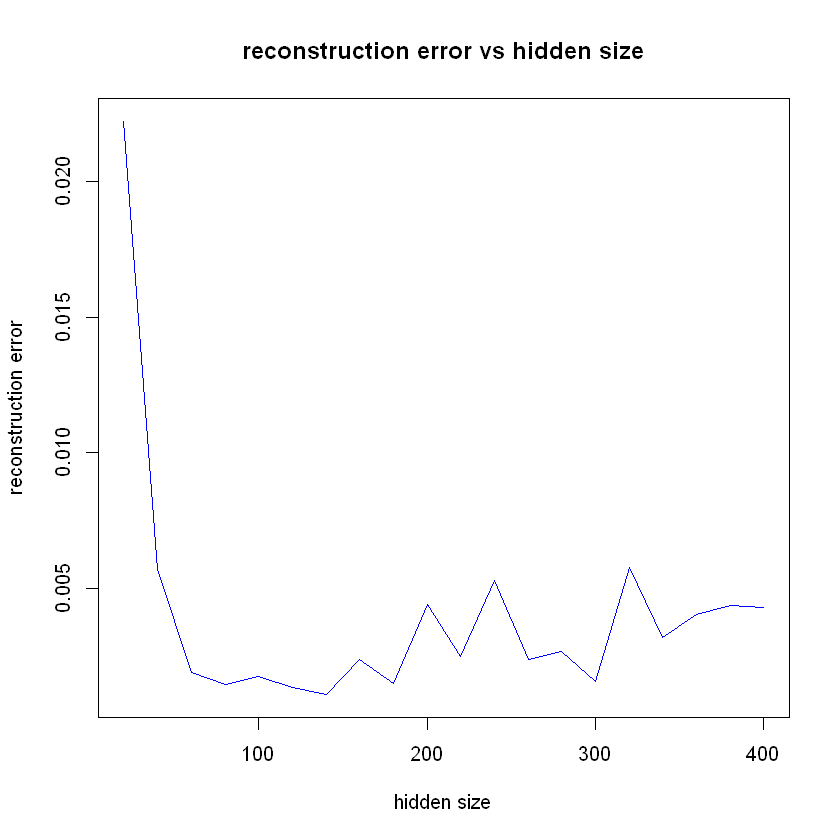

In [12]:
plot(seq(20, 400, 20), losses[,1], type='l', xlab = 'hidden size', ylab = 'reconstruction error', main = 'reconstruction error vs hidden size', col = 'blue')

IV. NN define and train

In [25]:
y <- "label"
x <- setdiff(names(train.frame), y)

train.frame[,y] <- as.factor(train.frame[,y])
untrain.frame[,y] <- as.factor(untrain.frame[,y])
test.frame[,y] <- as.factor(test.frame[,y])


In [37]:
classifier_train <- function()
{
    hids = seq(20, 400, 20)
    errors = c()
    for(hid in hids)
    { 
        NN.model2 <- h2o.deeplearning(
        x = 2:785,
        y = 1,
        training_frame = train.frame,
        validation_frame = test.frame,
        distribution = "multinomial",
        activation = "Rectifier",
        hidden = c(hid,hid,hid),
        l1 = 1e-4,
        epochs =200)
        errors = c(errors, h2o.mse(NN.model2 , valid = TRUE))
    }
    return (errors)
}

errors_noaugmented = classifier_train()

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |=====================================

V. Build augmented self-taught networks

In [38]:
self_taught <- function()
{
    hids = seq(20, 400, 20)
    errors = c()
    for(hid in hids)
    {
        NN.model1 = h2o.deeplearning(    
        x = 2:785, # select all pixels
        training_frame = train.frame, # specify the frame (imported file)    
        hidden = c(hid), # number of layers and their units
        epochs = 200, # maximum number of epoches  
        activation = 'Tanh', # activation function 
        autoencoder = TRUE  # is it an autoencoder? Yes!
        )

        extra_train = h2o.cbind(train.frame, (h2o.deepfeatures(NN.model1, train.frame, layer=1)))
        extra_test = h2o.cbind(test.frame, (h2o.deepfeatures(NN.model1, test.frame, layer=1)))
        NN.model2 <- h2o.deeplearning(
                x = 2:hid+785,
                y = 1,
                training_frame = extra_train,
                validation_frame = extra_test,
                distribution = "multinomial",
                activation = "Rectifier",
                hidden = c(hid,hid,hid),
                l1 = 1e-4,
                epochs = 200)

        errors = c(errors, h2o.mse(NN.model2 , valid = TRUE))
    }
    return (errors)
}

errors_augmented = self_taught()


  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |=====================================

VI. analysis is in pdf report

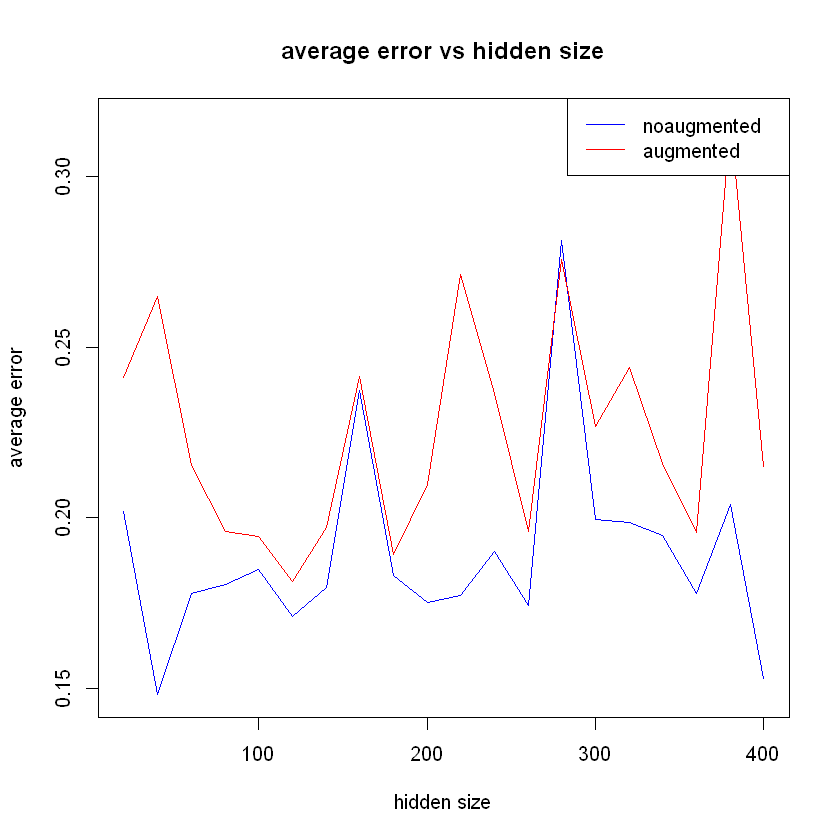

In [39]:
max_ = max(errors_augmented, errors_noaugmented)
min_ = min(errors_augmented, errors_noaugmented)

plot(seq(20, 400, 20), errors_noaugmented, type='l', xlab = 'hidden size', ylim = c(min_, max_), ylab = 'average error', main = 'average error vs hidden size', col = 'blue')
lines(seq(20, 400, 20), errors_augmented, col = 'red')
legend('topright',c("noaugmented","augmented"),col=c('blue','red'),lty=c(1,1))